Necessary imports:

In [581]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from matplotlib import colors

Implemented gradients:

In [582]:
def hsv2rgb(h, s, v): # supporting function converting hsv to rgb
    hsv = np.zeros(shape=(1, 3), dtype=float)
    hsv[0, 0] = h
    hsv[0, 1] = s
    hsv[0, 2] = v
    rgb = colors.hsv_to_rgb(hsv)
    r, g, b = rgb[0, 0], rgb[0, 1], rgb[0, 2]
    return (r, g, b)

# gradients

def gradient_rgb_bw(v):
    return (v, v, v)


def gradient_rgb_gbr(v):
    red = 0
    green = 0
    blue = 0

    if v <= 1/2:
        green = 1 - (v * 2)
        blue = 2 * v
    else:
        red = (v * 2) - 1
        blue = 2 - (v * 2)

    return (red, green, blue)


def gradient_rgb_gbr_full(v):
    red = 0
    green = 0
    blue = 0

    if v <= 0.25:
        green = 1
        blue = v * 4
    elif v <= 0.5:
        green = 2 - (v * 4)
        blue = 1
    elif v <= 0.75:
        red = (v * 4) - 2
        blue = 1
    else:
        red = 1
        blue = 4 - (v * 4)

    return (red, green, blue)


def gradient_rgb_wb_custom(v):
    red = 1
    green = 1
    blue = 1

    if v <= 1/7:
        green = 1 - (v * 7)
    elif v <= 2/7:
        red = 2 - (v * 7)
        green = 0
    elif v <= 3/7:
        red = 0
        green = (v * 7) - 2
    elif v <= 4/7:
        red = 0
        blue = 4 - (v * 7)
    elif v <= 5/7:
        red = (v * 7) - 4
        blue = 0
    elif v <= 6/7:
        green = 6 - (v * 7)
        blue = 0
    else:
        red = 7 - (v * 7)
        green = 0
        blue = 0

    return (red, green, blue)


def gradient_hsv_bw(v):
    return hsv2rgb(0, 0, v)


def gradient_hsv_gbr(v):
    return hsv2rgb(1/3 + (v * 2)/3, 1, 1)


def gradient_hsv_unknown(v):
    return hsv2rgb(1/3 - v/3, 1/2, 1)


def gradient_hsv_custom(v):
    return hsv2rgb(v, 1 - v, 1)

Supporting functions used for drawing the plot:

In [583]:
def get_name(gradient):
    return gradient.__name__.replace('gradient_', '').replace('_', '-').upper()

def draw_gradients(gradients, names):
    # set the font
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    # set other paramethers
    plt.rc('legend', fontsize=10)

    column_width_pt = 400 # Show in latex using \the\linewidth
    pt_per_inch = 72
    size = column_width_pt / pt_per_inch

    fig, axes = plt.subplots(nrows=len(gradients), sharex=True, figsize=(size, 0.75 * size))
    fig.subplots_adjust(top=1.00, bottom=0.05, left=0.25, right=0.95)


    for ax, gradient, name in zip(axes, gradients, names):
        # Create image with two lines and draw gradient on it
        img = np.zeros((2, 1024, 3))
        for i, v in enumerate(np.linspace(0, 1, 1024)):
            img[:, i] = gradient(v)

        im = ax.imshow(img, aspect='auto')
        im.set_extent([0, 1, 0, 1])
        ax.yaxis.set_visible(False)

        pos = list(ax.get_position().bounds)
        x_text = pos[0] - 0.25
        y_text = pos[1] + pos[3] / 2.
        fig.text(x_text, y_text, name, va='center', ha='left', fontsize=10)

    fig.savefig('gradients.pdf')

Main function:

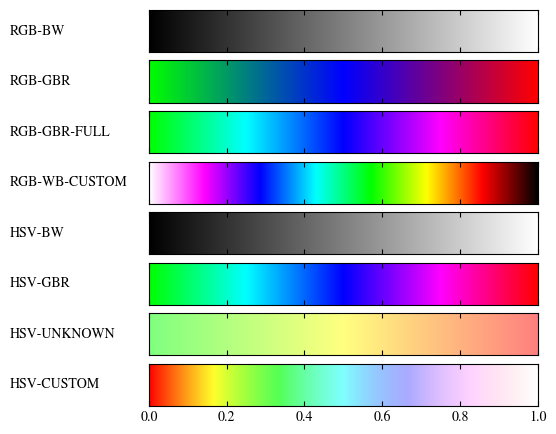

In [584]:
gradients = (gradient_rgb_bw, gradient_rgb_gbr, gradient_rgb_gbr_full, gradient_rgb_wb_custom,
                 gradient_hsv_bw, gradient_hsv_gbr, gradient_hsv_unknown, gradient_hsv_custom)

draw_gradients(gradients, [get_name(g) for g in gradients])

Map gradient:

In [585]:
def read_file(file_path) -> tuple[np.ndarray, np.ndarray]:
    with open(file_path, 'r') as file:
        # read the first line
        line = file.readline()  
        values = line.strip().split()
        params = np.array([np.int32(values[0]), np.int32(values[1]), np.float64(values[2]) / 1000], dtype=object)

        # read the rest of the file
        data = np.loadtxt(file)

        return (params, data)


#    __  z - vec(k)
#   |\
#     \
#      \
#       \--------->  y - vec(i)
#       |
#       |
#       |
#       v
#     x - vec(j)


class Vector3():
    def __init__(self, *args, **kwargs):
        if args:
            # because the args are an ndarray we use index 0
            self.i, self.j, self.k = args[0] 
        else:
            self.i = kwargs.get('i', 0)
            self.j = kwargs.get('j', 0)
            self.k = kwargs.get('k', 0)

        self.value = math.sqrt(self.i**2 + self.j**2 + self.k**2)
        
    def __repr__(self):
        return f'Vector3(i={self.i}, j={self.j}, k={self.k}, value={self.value})'
    

class Position():
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z


In [586]:
def map_gradient(value, angle):

    return hsv2rgb(1/3 - (((value - 44) / 110) / 3), # 44 ~ min data value, 110 ~ max - min data value
                   1 - (angle / 3.15), 
                   (angle / 3.15))

In [587]:
def draw_map(data, angles, params):
    # set the font
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    # set the rest of the paramethers
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['xtick.top'] = True
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['ytick.right'] = True
    plt.rcParams['ytick.left'] = True
    
    fig, ax = plt.subplots(figsize=(5, 5))

    # create a matrix holding the rgb values of the map points
    img = np.zeros((params[0], params[1], 3))
    for (i, j), v in np.ndenumerate(data):
        img[i, j] = map_gradient(v, angles[i, j])

    # convert to image and set the axes's range
    im = ax.imshow(img, aspect='auto')
    im.set_extent([0, params[0] - 1, params[1] - 1, 0])

    fig.savefig('map.pdf')

i: 0, j: 0, n: Vector3(i=-15.952272678804409, j=-5.3992132836311, k=56.806369, value=59.250232629629636)
i: 0, j: 1, n: Vector3(i=-8.48762401311854, j=1.4071519310653078, k=56.806369, value=57.45418519924661)
i: 0, j: 2, n: Vector3(i=-19.70069622406615, j=3.7628662869319687, k=56.806369, value=60.243175160099455)
i: 1, j: 0, n: Vector3(i=-9.145907464108, j=-9.533189858031548, k=56.806369, value=58.322318979747905)
i: 1, j: 1, n: Vector3(i=-6.131909657251878, j=6.469445176494673, k=56.806369, value=57.501457337188675)
i: 1, j: 2, n: Vector3(i=-10.943305304274485, j=6.469445176494673, k=56.806369, value=58.21145257454407)
i: 2, j: 0, n: Vector3(i=6.856727570418222, j=-8.8508479096138, k=56.806369, value=57.89918635575295)
i: 2, j: 1, n: Vector3(i=-6.131909657251878, j=-6.100689728380511, k=56.806369, value=57.46113721612919)
i: 2, j: 2, n: Vector3(i=-6.129396579572233, j=-6.100689728379761, k=56.806369, value=57.460869089805726)
i: 0, j: 0, n: 1.5724161190003536
i: 0, j: 1, n: 1.57295579

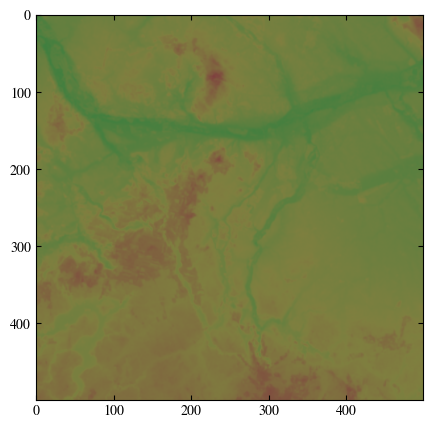

In [588]:
def calculate_normals(data, params) -> np.ndarray:
    normal_vectors = np.empty((params[0], params[1]), dtype=Vector3)
    dist = params[2]
    # tmp = np.empty((params[0], params[1], 2))


    # calculate normal vectors, skip the last row and column 
    # * * -
    # * * -
    # - - -
    for (x, y), v in np.ndenumerate(data[:-1, :-1]):
        normal_vectors[x, y] = Vector3( np.cross(
                                        np.array( [dist, 0, data[x, y + 1] - v] ), 
                                        np.array( [0, dist, data[x + 1, y] - v] ) ) )
        # tmp[x, y] = ((data[x, y + 1] - v), (data[x + 1, y] - v))
    
    # calculate normal vectors for the last row (no last value)
    # - - -
    # - - -
    # * * -
    x = params[0] - 1
    for (_, y), v in np.ndenumerate(data[-1:, :-1]):
        normal_vectors[x, y] = Vector3( np.cross(
                                        np.array( [0, -dist, data[x - 1, y] - v] ), 
                                        np.array( [dist, 0, data[x, y + 1] - v] ) ) )
        # tmp[x, y] = ((data[x, y + 1] - v), (data[x - 1, y] - v))
    
    # calculate normal vectors for the last column (no last value)
    # - - *
    # - - *
    # - - -
    y = params[1] - 1
    for (x, _), v in np.ndenumerate(data[:-1, -1:]):
        normal_vectors[x, y] = Vector3( np.cross(
                                        np.array( [0, dist, data[x + 1, y] - v] ), 
                                        np.array( [-dist, 0, data[x, y - 1] - v] ) ) )
        # tmp[x, y] = ((data[x, y - 1] - v), (data[x + 1, y] - v))
    
    # calculate normal vector for the bottom right value
    # - - -
    # - - -
    # - - *
    x = params[0] - 1
    y = params[1] - 1
    v = data[x, y]
    normal_vectors[x, y] = Vector3( np.cross(
                                    np.array( [-dist, 0, data[x, y - 1] - v] ), 
                                    np.array( [0, -dist, data[x - 1, y] - v] ) ) )
    # tmp[x, y] = ((data[x, y - 1] - v), (data[x - 1, y] - v))

    # print(np.min(tmp), np.max(tmp))
        
    return normal_vectors


def calculate_angles(data, normal_vectors, params, sun) -> np.ndarray:
    angles = np.empty((params[0], params[1]))
    dist = params[2]

    for x, y in np.ndindex(normal_vectors.shape[:2]):
        # set the point's world position
        y_pos = (y * dist)
        x_pos = (x * dist)
        z_pos = data[x, y]

        # calculate the direction from which the sun is hitting the point
        dir_vec_val = math.sqrt((x_pos - sun.x)**2 + (y_pos - sun.y)**2 + (z_pos - sun.z)**2)
        dir_vec = (((x_pos - sun.x) / dir_vec_val), # sun's - i
                   ((y_pos - sun.y) / dir_vec_val), # sun's - j
                   ((z_pos - sun.z) / dir_vec_val)) # sun's - k

        numerator = (dir_vec[0] * normal_vectors[x, y].i + 
                     dir_vec[1] * normal_vectors[x, y].j + 
                     dir_vec[2] * normal_vectors[x, y].k)
        
        denominator = dir_vec_val * normal_vectors[x, y].value

        angle_cosine = max(-1, min(1, numerator / denominator)) # clamp the cosine value
        angles[x, y] = math.acos(angle_cosine)

    return angles

params, data = read_file('data/big.dem')
dist = 1 #params[2]

# define sun's position
sun = Position(150 * dist, 150 * dist, 250) # NOTE: parameter

normal_vectors = calculate_normals(data, params)
for (i, j), v in np.ndenumerate(normal_vectors[:3, :3]):
    print(f'i: {i}, j: {j}, n: {v}')
# print(normal_vectors[0, 0])
# print(normal_vectors[499, 0])
# print(normal_vectors[0, 499])
# print(normal_vectors[499, 499])


angles = calculate_angles(data, normal_vectors, params, sun)
for (i, j), v in np.ndenumerate(angles[:3, :3]):
    print(f'i: {i}, j: {j}, n: {v}')

# print(angles[0, 0])
# print(angles[499, 0])
# print(angles[0, 499])
# print(angles[499, 499])

print(np.min(angles), np.max(angles))

draw_map(data, angles, params)
    
    